## Library import

In [1]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

### Load dataset

In [2]:
df = pd.read_csv("../data/Heart Prediction Quantum Dataset.csv")
df_Y = df["HeartDisease"]
del df["HeartDisease"]


# Normalisation des données
scaler = StandardScaler()
X = scaler.fit_transform(df.values)
y = df_Y.values

# Conversion en tenseurs PyTorch
X_tensor = torch.FloatTensor(X)
y_tensor = torch.FloatTensor(y).view(-1, 1)  # Reshape pour correspondre à la dimension de sortie

### Test sur l'ensemble des données

In [6]:
# Division en ensembles d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Création des DataLoaders
batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [9]:
# Ajuster le modèle aux dimensions de votre dataset
input_dim = X.shape[1]  # Nombre de caractéristiques
hidden_dim = 16
output_dim = 1  # Classification binaire

model = nn.Sequential(
    nn.Linear(input_dim, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, output_dim),
    nn.Sigmoid()
)

In [10]:
# Définir la fonction de perte et l'optimiseur
criterion = nn.BCELoss()  # Binary Cross Entropy pour classification binaire
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Paramètres d'entraînement
num_epochs = 100
patience = 10  # Pour early stopping

# Listes pour suivre les performances
train_losses = []
val_losses = []
best_val_loss = float('inf')
early_stop_counter = 0

# Boucle d'entraînement
for epoch in range(num_epochs):
    # Mode entraînement
    model.train()
    train_loss = 0
    
    for X_batch, y_batch in train_loader:
        # Forward pass
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        
        # Backward pass et optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Mode évaluation
    model.eval()
    val_loss = 0
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    # Afficher les progrès
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        
    if early_stop_counter >= patience:
        print(f"Early stopping après {epoch+1} epochs")
        break

Epoch 1/100, Train Loss: 0.6835, Val Loss: 0.6640
Epoch 2/100, Train Loss: 0.6666, Val Loss: 0.6434
Epoch 3/100, Train Loss: 0.6478, Val Loss: 0.6213
Epoch 4/100, Train Loss: 0.6266, Val Loss: 0.5948
Epoch 5/100, Train Loss: 0.6011, Val Loss: 0.5625
Epoch 6/100, Train Loss: 0.5688, Val Loss: 0.5246
Epoch 7/100, Train Loss: 0.5345, Val Loss: 0.4812
Epoch 8/100, Train Loss: 0.4879, Val Loss: 0.4370
Epoch 9/100, Train Loss: 0.4530, Val Loss: 0.3909
Epoch 10/100, Train Loss: 0.4043, Val Loss: 0.3496
Epoch 11/100, Train Loss: 0.3746, Val Loss: 0.3141
Epoch 12/100, Train Loss: 0.3447, Val Loss: 0.2847
Epoch 13/100, Train Loss: 0.3249, Val Loss: 0.2600
Epoch 14/100, Train Loss: 0.3012, Val Loss: 0.2406
Epoch 15/100, Train Loss: 0.2878, Val Loss: 0.2228
Epoch 16/100, Train Loss: 0.2640, Val Loss: 0.2064
Epoch 17/100, Train Loss: 0.2549, Val Loss: 0.1929
Epoch 18/100, Train Loss: 0.2487, Val Loss: 0.1816
Epoch 19/100, Train Loss: 0.2356, Val Loss: 0.1727
Epoch 20/100, Train Loss: 0.2257, Val Lo

In [11]:
from sklearn.model_selection import KFold

# Paramètres
k_folds = 5
num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# K-Fold Cross Validation
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
fold_results = []

for fold, (train_ids, val_ids) in enumerate(kfold.split(X_tensor)):
    print(f"Fold {fold+1}/{k_folds}")
    
    # Préparation des données pour ce fold
    X_train_fold = X_tensor[train_ids]
    y_train_fold = y_tensor[train_ids]
    X_val_fold = X_tensor[val_ids]
    y_val_fold = y_tensor[val_ids]
    
    # DataLoaders
    train_dataset = TensorDataset(X_train_fold, y_train_fold)
    val_dataset = TensorDataset(X_val_fold, y_val_fold)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Réinitialiser le modèle
    model = nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, output_dim),
        nn.Sigmoid()
    ).to(device)
    
    # Réinitialiser l'optimiseur
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Entraînement
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            val_preds = []
            val_true = []
            
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                val_loss += loss.item()
                
                val_preds.extend((y_pred > 0.5).cpu().numpy())
                val_true.extend(y_batch.cpu().numpy())
        
        val_loss /= len(val_loader)
        
        # Calculer les métriques
        val_acc = accuracy_score(val_true, val_preds)
        if epoch == num_epochs - 1:
            print(f"Fold {fold+1} - Accuracy: {val_acc:.4f}, Loss: {val_loss:.4f}")
            fold_results.append(val_acc)

# Résultat global de la validation croisée
print(f"Performance moyenne sur {k_folds} folds: {np.mean(fold_results):.4f} ± {np.std(fold_results):.4f}")

Fold 1/5
Fold 1 - Accuracy: 0.9400, Loss: 0.1315
Fold 2/5
Fold 2 - Accuracy: 0.8800, Loss: 0.1966
Fold 3/5
Fold 3 - Accuracy: 0.9000, Loss: 0.4253
Fold 4/5
Fold 4 - Accuracy: 0.9300, Loss: 0.1489
Fold 5/5
Fold 5 - Accuracy: 0.9000, Loss: 0.1772
Performance moyenne sur 5 folds: 0.9100 ± 0.0219


In [12]:
# Charger le meilleur modèle
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Prédictions sur l'ensemble de validation
with torch.no_grad():
    y_pred_proba = model(X_val)
    y_pred = (y_pred_proba > 0.5).float()

# Conversion en numpy pour les métriques
y_val_np = y_val.numpy()
y_pred_np = y_pred.numpy()

# Calcul des métriques
accuracy = accuracy_score(y_val_np, y_pred_np)
precision = precision_score(y_val_np, y_pred_np)
recall = recall_score(y_val_np, y_pred_np)
f1 = f1_score(y_val_np, y_pred_np)
conf_matrix = confusion_matrix(y_val_np, y_pred_np)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Matrice de confusion:")
print(conf_matrix)

Accuracy: 0.9400
Precision: 0.9821
Recall: 0.9167
F1 Score: 0.9483
Matrice de confusion:
[[39  1]
 [ 5 55]]


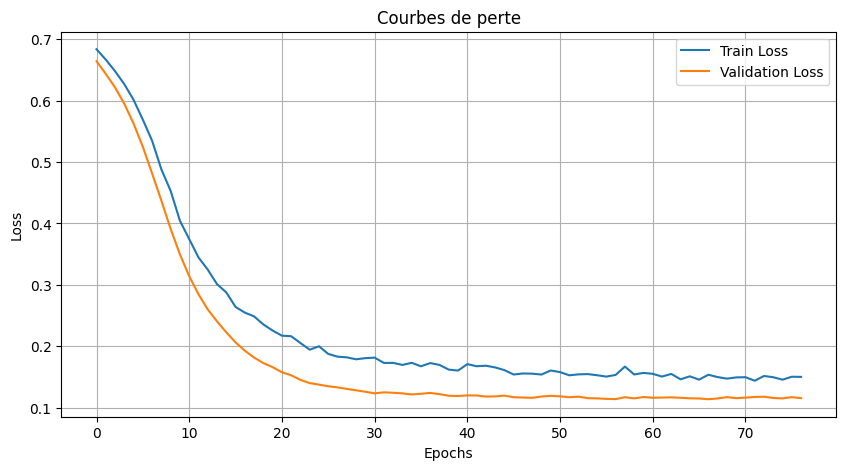

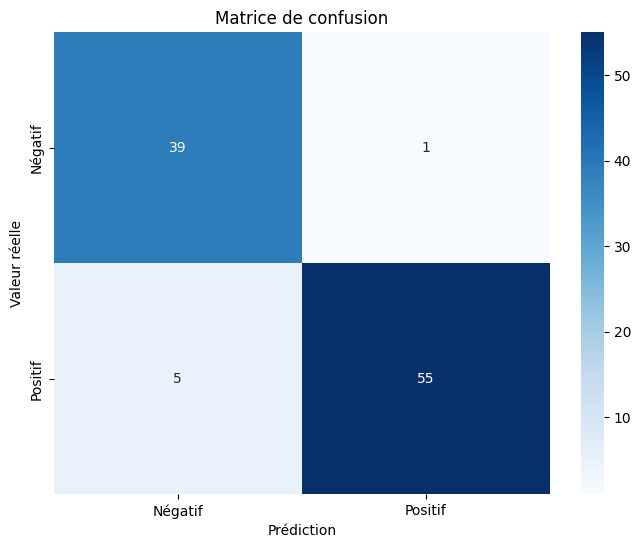

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Courbes d'apprentissage
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Courbes de perte')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Négatif', 'Positif'], 
            yticklabels=['Négatif', 'Positif'])
plt.title('Matrice de confusion')
plt.xlabel('Prédiction')
plt.ylabel('Valeur réelle')
plt.show()

In [17]:
from sklearn.model_selection import GridSearchCV
from skorch import NeuralNetClassifier
import torch.nn.functional as F

# Définir le modèle avec skorch (wrapper PyTorch pour sklearn)
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x.squeeze(-1)  # Supprimer la dimension finale pour correspondre à y

# Création du wrapper skorch avec BCELoss modifié
net = NeuralNetClassifier(
    MLPClassifier,
    module__input_dim=input_dim,
    module__hidden_dim=16,
    module__output_dim=1,
    max_epochs=50,
    lr=0.001,
    optimizer=optim.Adam,
    criterion=nn.BCELoss,
    device='cuda' if torch.cuda.is_available() else 'cpu',
)

# Grille de paramètres à tester
param_grid = {
    'lr': [0.001, 0.01, 0.0001],
    'module__hidden_dim': [8, 16, 32],
    'max_epochs': [50, 100],
    'batch_size': [16, 32, 64]
}

# Recherche par grille avec validation croisée
gs = GridSearchCV(net, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
X = X.astype(np.float32)
y = y.astype(np.float32)

gs.fit(X, y.ravel())  # utiliser numpy array

# Meilleurs paramètres
print("Meilleurs paramètres:", gs.best_params_)
print("Meilleur score:", gs.best_score_)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7318       0.4030        0.7301  0.0648
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6729       0.6418        0.6684  0.0695
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6947       0.4627        0.6881  0.0702
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7004       0.4776        0.6908  0.0692
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6767       0.6866        0.6502  0.0618
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7085       0.4